In [55]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import find_dotenv, load_dotenv
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

load_dotenv(find_dotenv())
sys.path.append(os.getenv('PROJECT_DIR'))

from src.metrics import bias, mae, mape
from src.visualization import yearly_seasonality_plot, subseries_yearly_seasonality_plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and Preprocess Data

In [5]:
# Load data
df = pd.read_csv("../data/raw/Air_Traffic_Passenger_Statistics.csv")

# Data Preprocessing
df['Activity Period Start Date'] = pd.to_datetime(df['Activity Period Start Date'])
df = df.groupby(by=['Activity Period Start Date']).agg({'Passenger Count': 'sum'}).reset_index()
df = df.rename(columns={
    "Activity Period Start Date": "date",
    "Passenger Count": "passenger_count"
})

# Split data Pre and Post Covid 19 Pandemic
1. The reason we split it because due to behavior of the passengers are different between pre and post Covid 19 Pandemic. 
2. From previous EDA, the trend of the data and the pattern of seasonality for both are different. 

In [204]:
# Split data between Pre and Post Covid 19 Pandemic
break_point = '2020-03-01'
df_pre_covid = df[df['date']<break_point]
df_post_covid = df[df['date']>=break_point]

# Split data for train and test
train_pre_covid = df_pre_covid[df_pre_covid['date']<='2019-02-01']
test_pre_covid = df_pre_covid[df_pre_covid['date']>'2019-02-01']
train_post_covid = df_post_covid[df_post_covid['date']<='2022-10-01']
test_post_covid = df_post_covid[df_post_covid['date']>'2022-10-01']

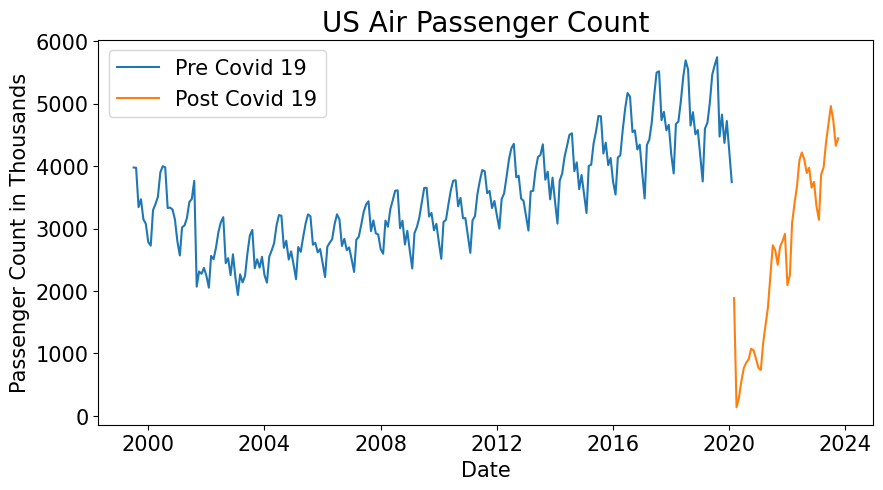

In [116]:
# Visualize Pre and Post Covid 19 Pandemic
plt.figure(figsize=(10, 5))
plt.plot(df_pre_covid['date'], df_pre_covid['passenger_count']/1_000, label='Pre Covid 19')
plt.plot(df_post_covid['date'], df_post_covid['passenger_count']/1_000, label='Post Covid 19')
plt.title("US Air Passenger Count", size=20)
plt.xlabel("Date", size=15)
plt.ylabel("Passenger Count in Thousands", size=15)
plt.legend()
plt.show()

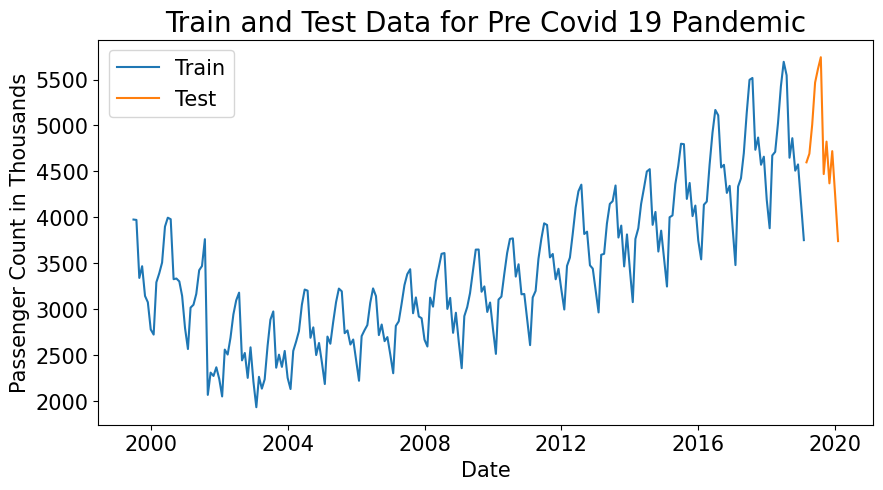

In [117]:
# Visualize Train and Testing Data for Pre Covid 19 Pandemic
plt.figure(figsize=(10, 5))
plt.plot(train_pre_covid['date'], train_pre_covid['passenger_count']/1_000, label='Train')
plt.plot(test_pre_covid['date'], test_pre_covid['passenger_count']/1_000, label='Test')
plt.title("Train and Test Data for Pre Covid 19 Pandemic", size=20)
plt.xlabel("Date", size=15)
plt.ylabel("Passenger Count in Thousands", size=15)
plt.legend()
plt.show()

Text(0.5, 0.98, 'Time Series Components (Pre Covid 19 Pandemic)')

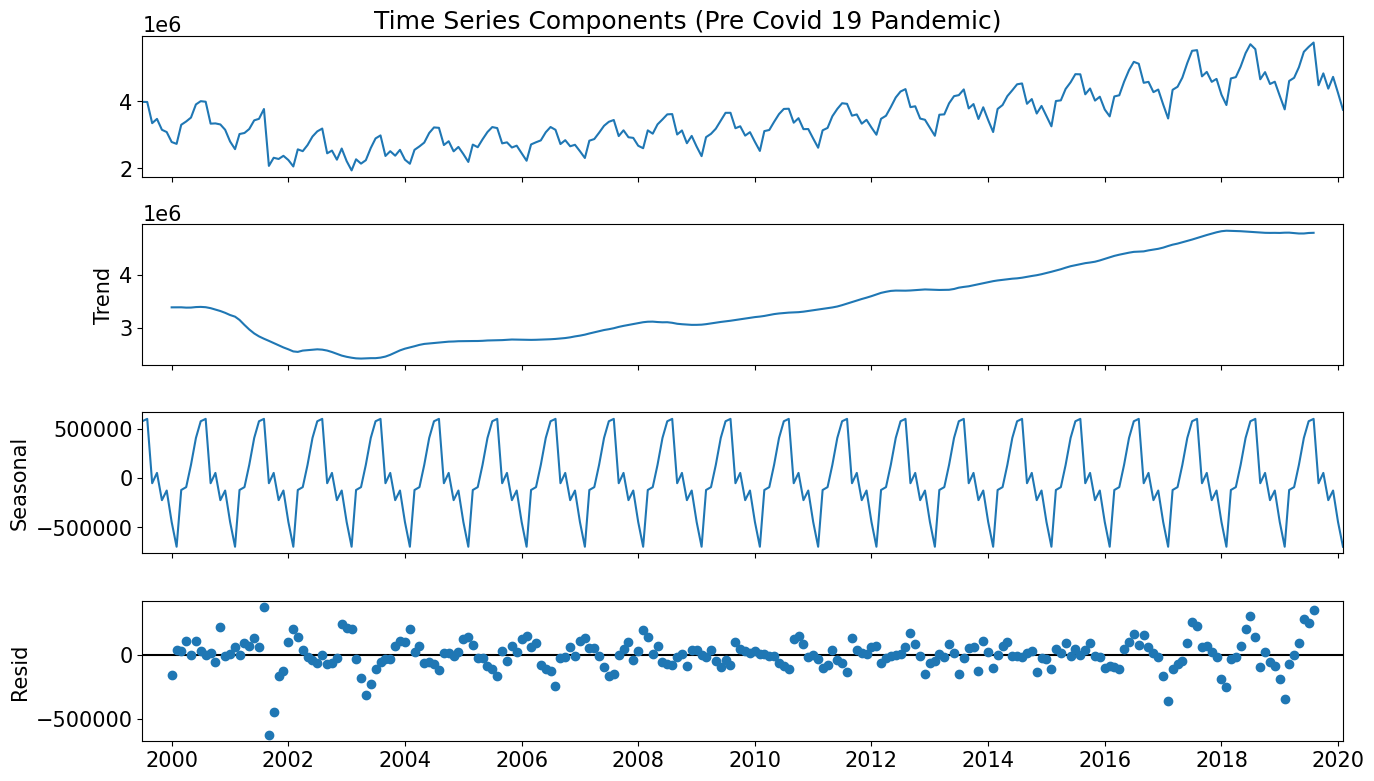

In [118]:
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)

result = seasonal_decompose(df_pre_covid.set_index('date'), model='additive')
fig = result.plot()
fig.suptitle('Time Series Components (Pre Covid 19 Pandemic)')

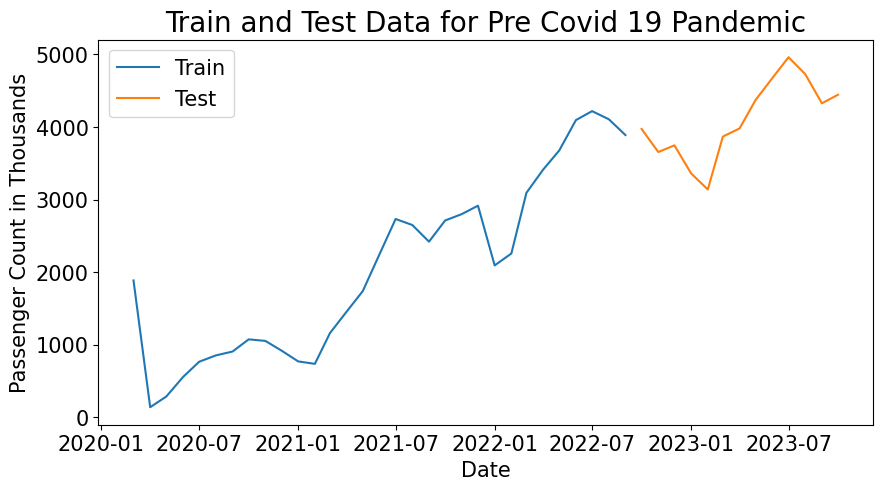

In [119]:
# Visualize Train and Testing Data for Post Covid 19 Pandemic
plt.figure(figsize=(10, 5))
plt.plot(train_post_covid['date'], train_post_covid['passenger_count']/1_000, label='Train')
plt.plot(test_post_covid['date'], test_post_covid['passenger_count']/1_000, label='Test')
plt.title("Train and Test Data for Pre Covid 19 Pandemic", size=20)
plt.xlabel("Date", size=15)
plt.ylabel("Passenger Count in Thousands", size=15)
plt.legend()
plt.show()

Text(0.5, 0.98, 'Time Series Components (Post Covid 19 Pandemic)')

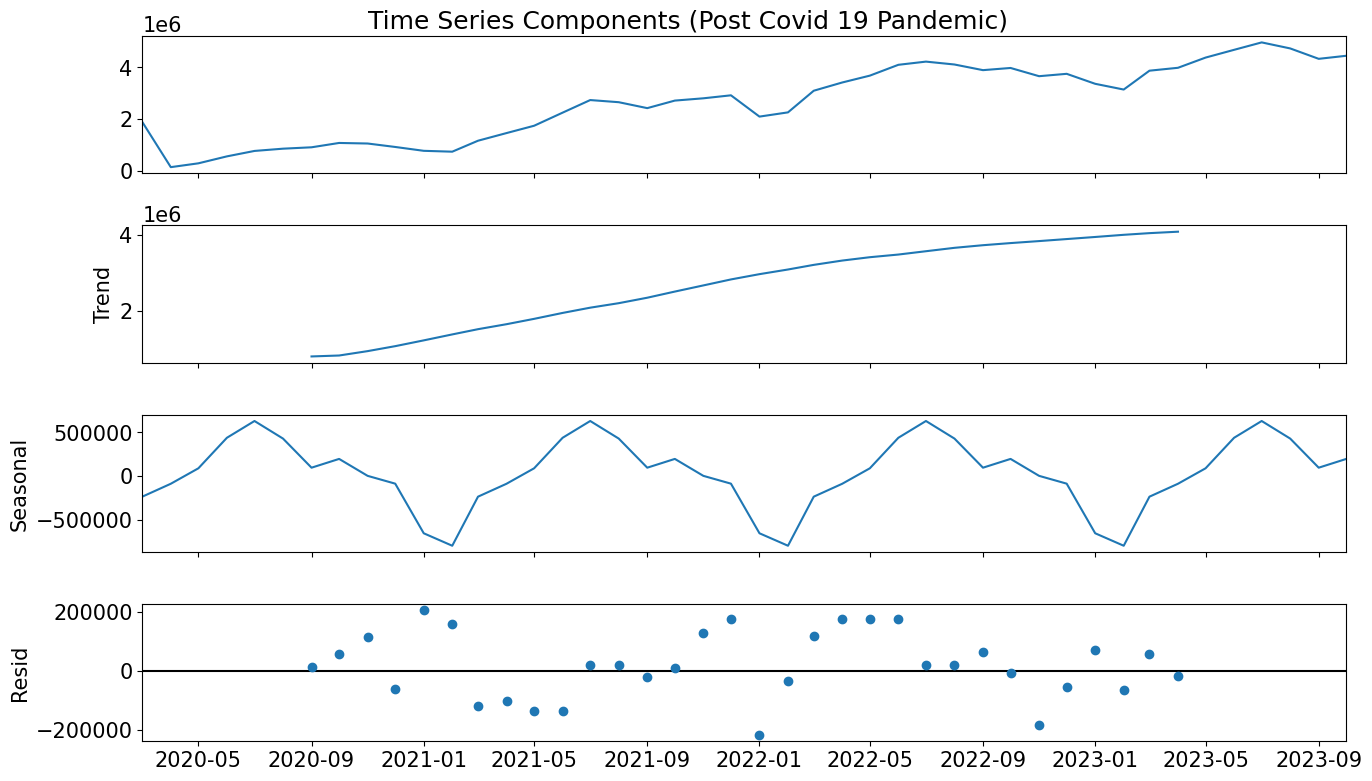

In [120]:
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)
result = seasonal_decompose(df_post_covid.set_index('date'), model='additive')
fig = result.plot()
fig.suptitle('Time Series Components (Post Covid 19 Pandemic)')

# Check Stationarity of Our Dataset

In [121]:
def check_stationarity(data, column):
    adftest = adfuller(data[column], autolag='AIC', regression='ct')
    print("ADF Test Results")
    print("Null Hypothesis: The series has a unit root (non-stationary)")
    print("ADF-Statistic:", adftest[0])
    print("P-Value:", adftest[1])
    print("Number of lags:", adftest[2])
    print("Number of observations:", adftest[3])
    print("Critical Values:", adftest[4])
    print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")

In [122]:
check_stationarity(train_pre_covid, 'passenger_count')

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -3.846903554564858
P-Value: 0.014331529533824173
Number of lags: 13
Number of observations: 222
Critical Values: {'1%': -4.000138811415506, '5%': -3.430454069218963, '10%': -3.1387785328059983}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [123]:
check_stationarity(train_post_covid, 'passenger_count')

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -4.303428548924835
P-Value: 0.0031079739466668968
Number of lags: 9
Number of observations: 21
Critical Values: {'1%': -4.468818601662887, '5%': -3.6449459334845047, '10%': -3.261490621963071}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


# Check Seasonality

## Seasonality Plot

D:\Documents\GitHub\us-air-passenger-forecast\src\visualization\visualize.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'month'] = data[date_column].dt.month
D:\Documents\GitHub\us-air-passenger-forecast\src\visualization\visualize.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'year'] = data[date_column].dt.year


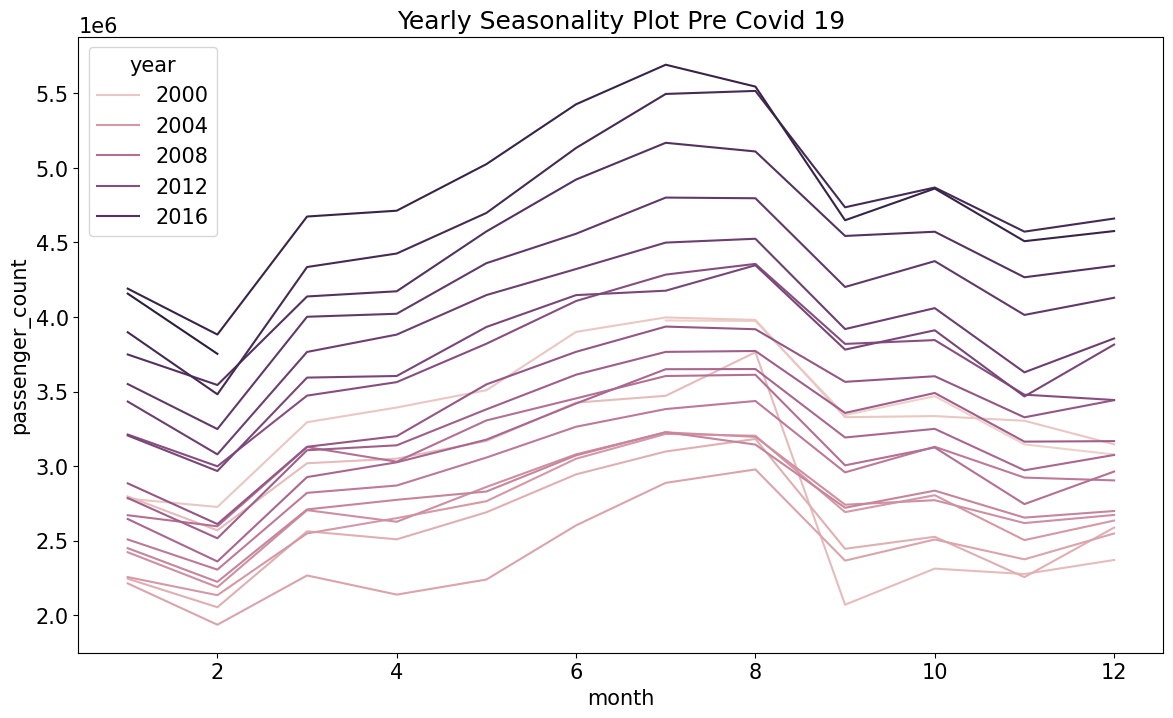

D:\Documents\GitHub\us-air-passenger-forecast\src\visualization\visualize.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'month'] = data[date_column].dt.month
D:\Documents\GitHub\us-air-passenger-forecast\src\visualization\visualize.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'year'] = data[date_column].dt.year


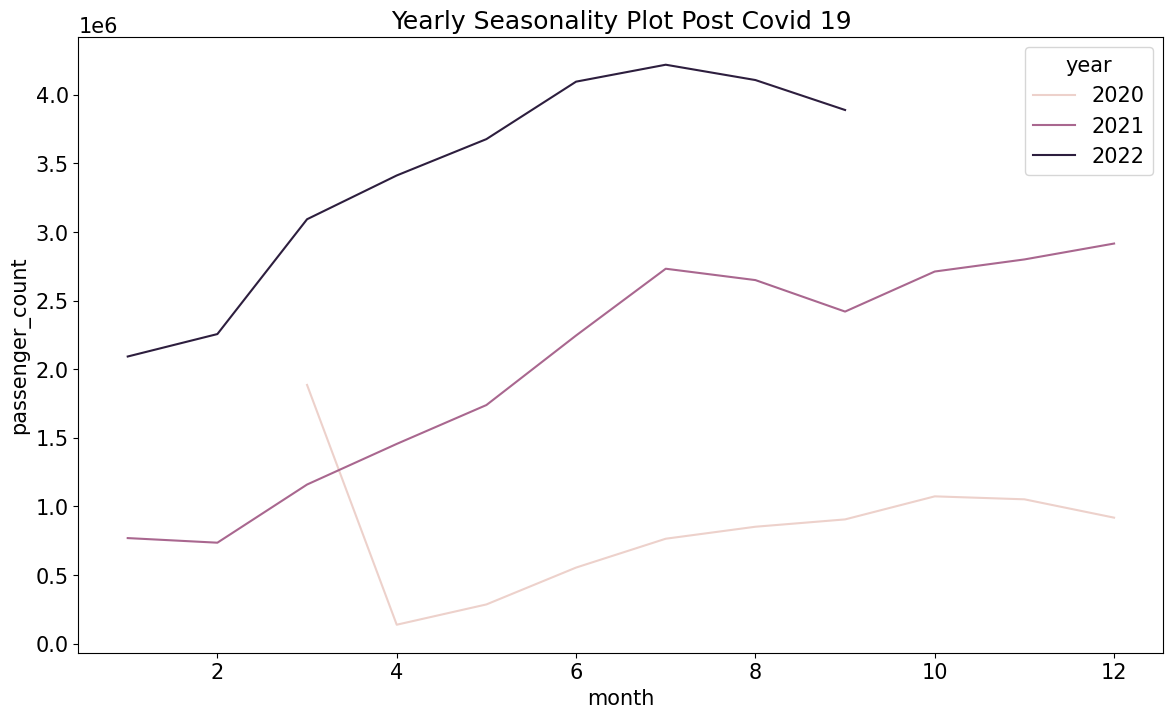

In [124]:
yearly_seasonality_plot(train_pre_covid, 'date', 'passenger_count', 'Yearly Seasonality Plot Pre Covid 19')
yearly_seasonality_plot(train_post_covid, 'date', 'passenger_count', 'Yearly Seasonality Plot Post Covid 19')

## Sub Series Seasonality Plots

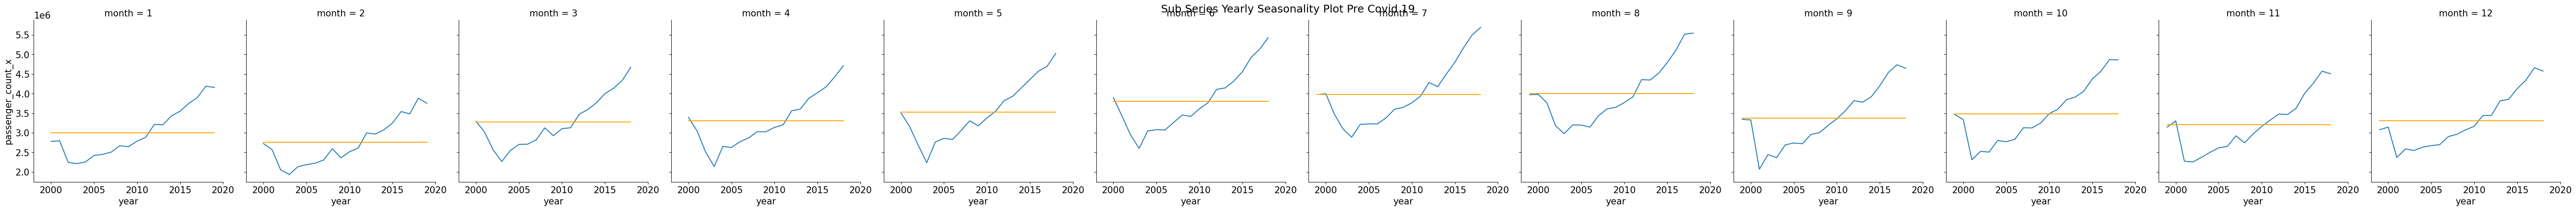

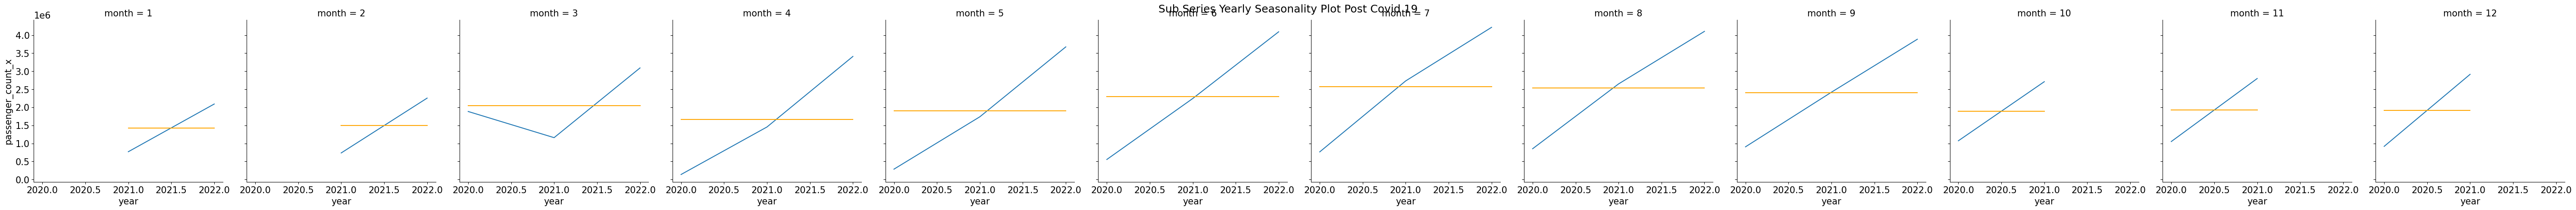

In [125]:
subseries_yearly_seasonality_plot(train_pre_covid, 'date', 'passenger_count', 'Sub Series Yearly Seasonality Plot Pre Covid 19')
subseries_yearly_seasonality_plot(train_post_covid, 'date', 'passenger_count', 'Sub Series Yearly Seasonality Plot Post Covid 19')

Explanation:
1. From the Pre Covid 19 Pandemic, there's a positive trend overtime and patten exists where the peck of the passenger count occurs in `August`.
2. From the Post Covid 19 Pandemic, there's a positive trend overtime (due to recovery from the pandemic), but there's no significant pattern.

## Autocorrelation and Partial Autocorrelation Plot

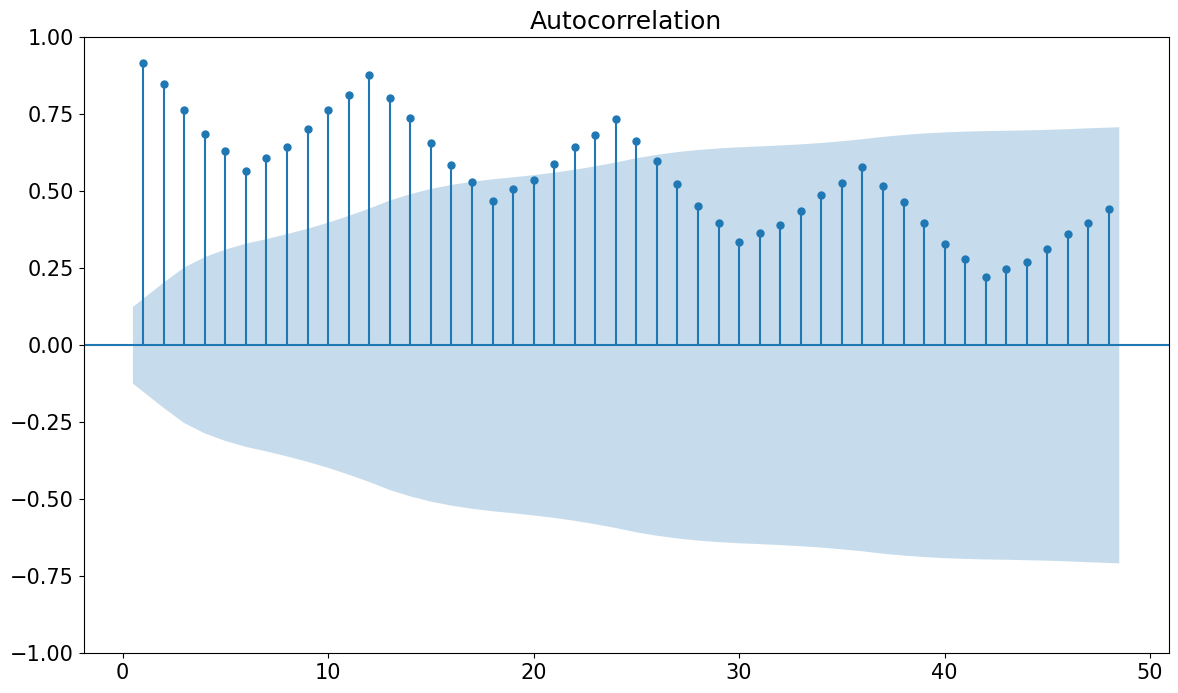

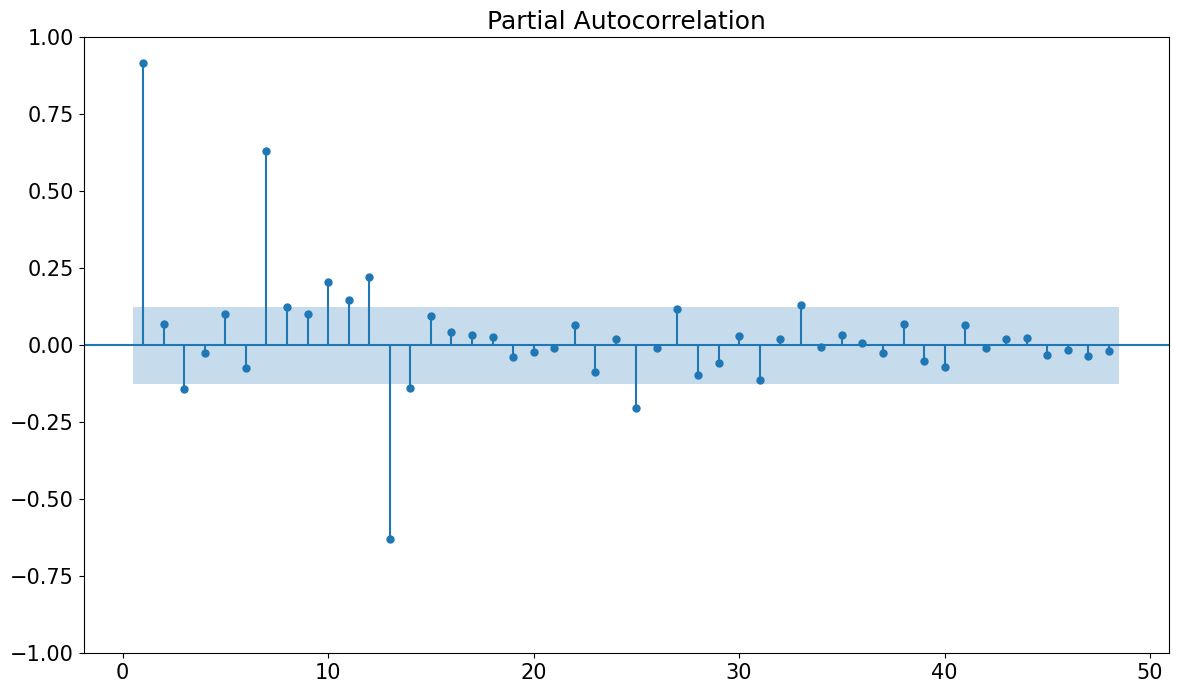

In [126]:
plot_acf(df_pre_covid['passenger_count'], zero=False, lags=48)
plot_pacf(df_pre_covid['passenger_count'], zero=False, lags=48)
plt.show()

Explanation:
1. ACF plot confirms the yearly seasonality because of the string correlation for at 12 lag interval

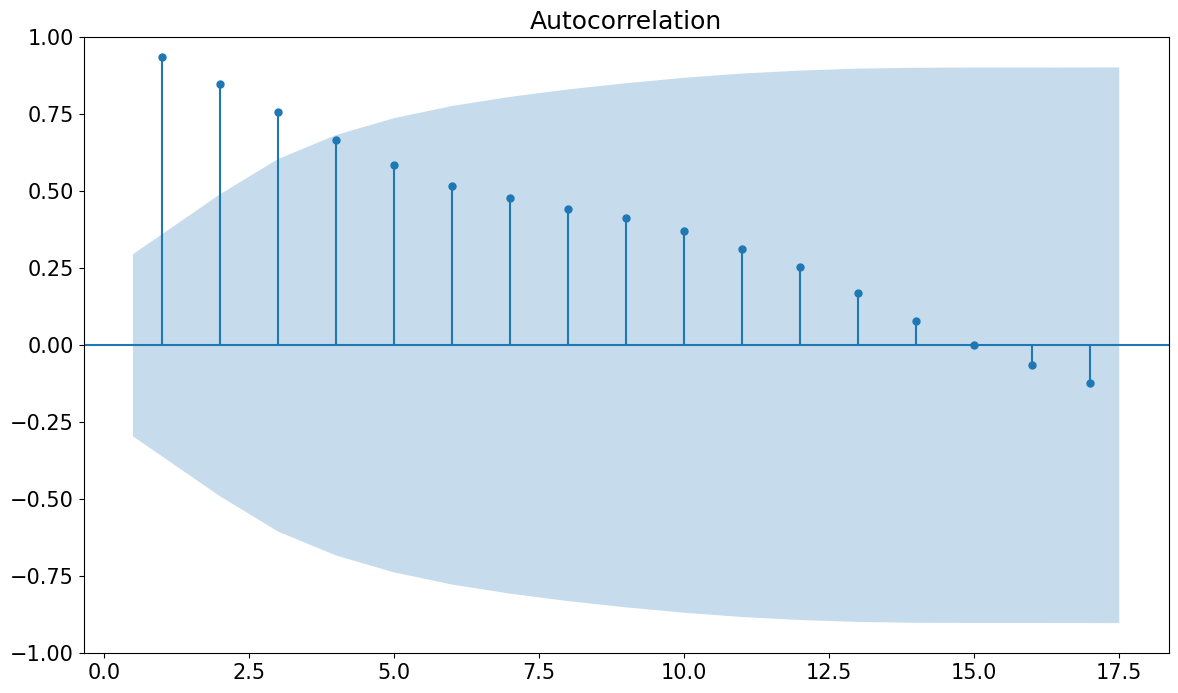

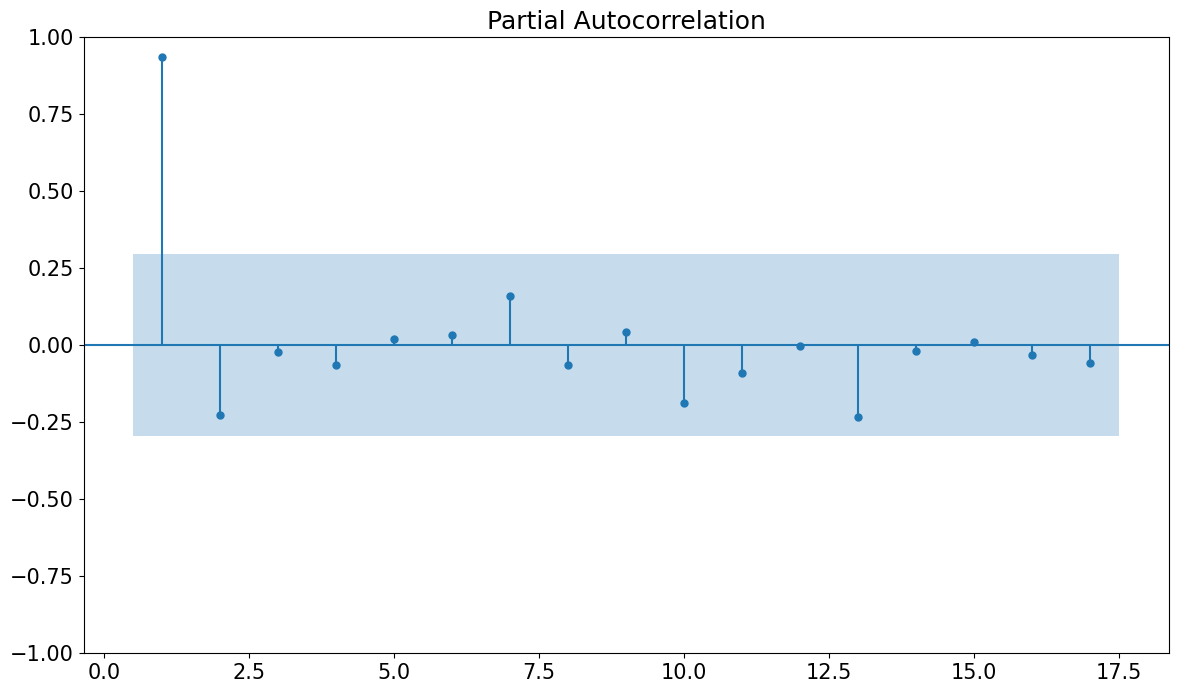

In [127]:
plot_acf(df_post_covid['passenger_count'], zero=False)
plot_pacf(df_post_covid['passenger_count'], zero=False)
plt.show()

Explanation:
1. Changing in behavior after the Covid 19 Pandemic which we can see that there's a `Tails-Off` at Autocorrelation Plot and `Cuts-Off` at Partial Autocorrelation plot. Suggesting a MA model

# Data Preparation for Modelling

In [135]:
# Split data between Pre and Post Covid 19 Pandemic
break_point = '2020-03-01'
df_pre_covid = df[df['date']<break_point]
df_post_covid = df[df['date']>=break_point]

# Split data for train and test
train_pre_covid = df_pre_covid[df_pre_covid['date']<='2019-02-01']
test_pre_covid = df_pre_covid[df_pre_covid['date']>'2019-02-01']
train_post_covid = df_post_covid[df_post_covid['date']<='2022-09-01']
test_post_covid = df_post_covid[df_post_covid['date']>'2022-09-01']

# Pre Covid

## Modelling ARIMA

### Find Best Parameter

In [136]:
# find the best model for the ARIMA method
best_p, best_d, best_q = None, None, None
d=1
best_aic = float('inf')
for p in range(0, 4):
    for q in range(0, 4):
        model = ARIMA(
            endog=train_pre_covid.set_index('date'),
            order=(p, d, q),
            freq='MS'
        )
        results = model.fit()
        if best_aic > results.aic:
            best_p, best_d, best_q = (p, d, q)
            best_aic = results.aic

print(f"Best Params (p, d, q): {(best_p, best_d, best_q)}")

# Train Arima Using The Best (p, d, s) Params
best_arima_model = ARIMA(
    endog=train_pre_covid.set_index('date'),
    order=(best_p, best_d, best_q),
    freq='MS'
)
results = best_arima_model.fit()
# Predict Using ARIMA
prediction = results.get_forecast(steps=12).predicted_mean

c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\923

Best Params (p, d, q): (2, 1, 2)


c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Plot the Results

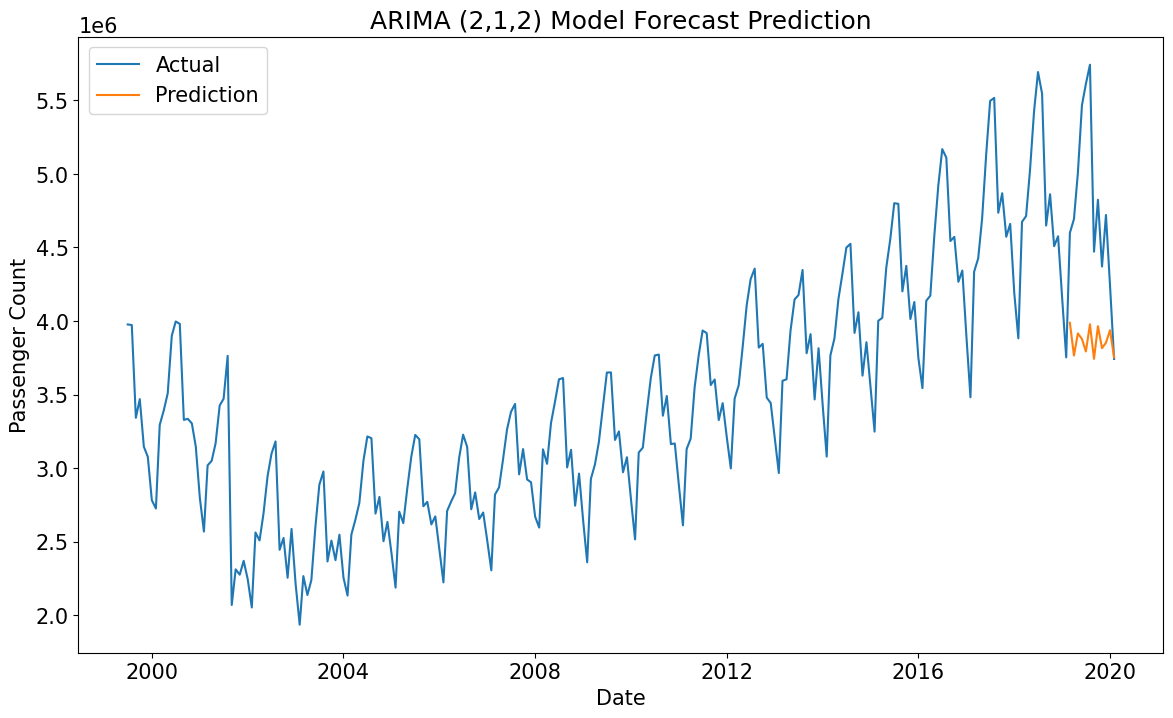

In [137]:
plt.plot(df_pre_covid['date'], df_pre_covid['passenger_count'], label='Actual')
plt.plot(prediction.index, prediction, label='Prediction')
plt.xlabel("Date", size=15)
plt.ylabel("Passenger Count", size=15)
plt.legend()
plt.title('ARIMA (2,1,2) Model Forecast Prediction')
plt.show()

### Analyze Residuals

In [138]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        passenger_count   No. Observations:                  236
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3286.394
Date:                Wed, 17 Jan 2024   AIC                           6582.788
Time:                        09:50:51   BIC                           6600.086
Sample:                    07-01-1999   HQIC                          6589.762
                         - 02-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7306      0.005   -319.692      0.000      -1.741      -1.720
ar.L2         -0.9991      0.005   -213.297      0.000      -1.008      -0.990
ma.L1          1.7341      0.063     27.593      0.000       1.611       1.857
ma.L2          0.9976      0.067     14.880      0.000       0.866       1.129
sigma2      8.569e+10   1.55e-12   5.52e+22      0.000    8.57e+10    8.57e+10
===================================================================================
Ljung-Box (L1) (Q):                   5.75   Jarque-Bera (JB):               155.99
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                            -0.84
Prob(H) (two-sided):                  0.84   Kurtosis:                         6.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.38e+38. Standard errors may be unstable.
"""

Prob(Q) and Prob(JB) are 0 which means they both reject the null hypothesis which states that the residuals are `normally distributed` and `uncorrelated` 

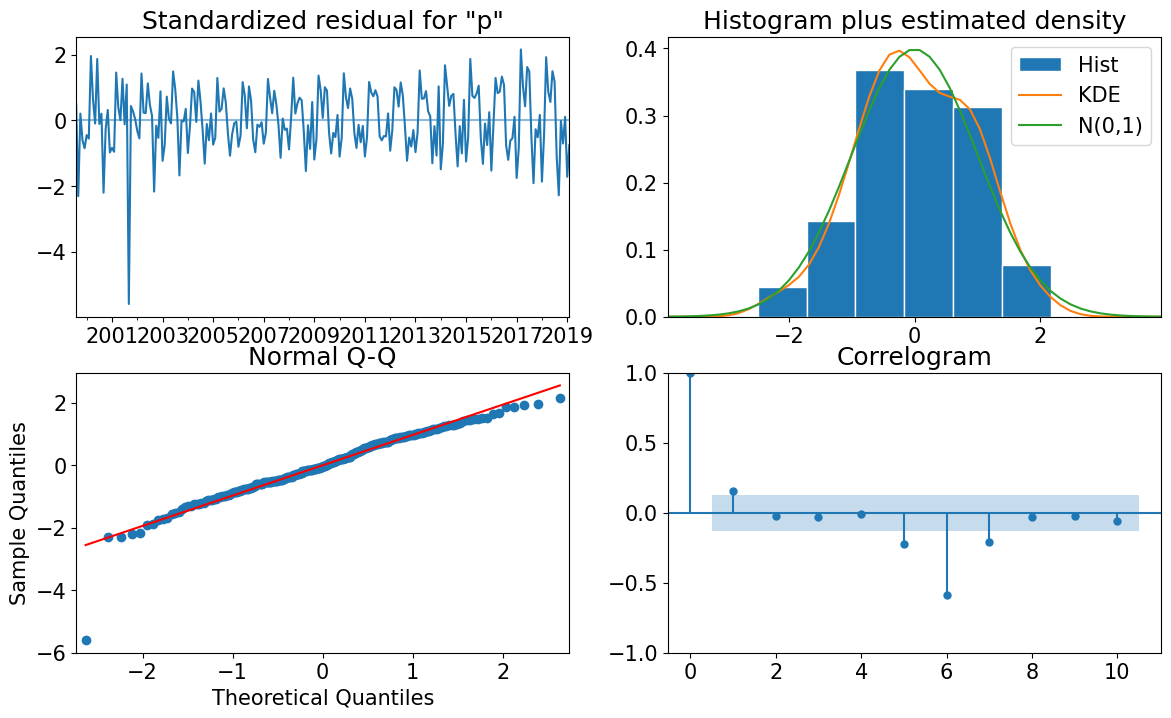

In [139]:
results.plot_diagnostics()
plt.show()

Explanation:
1. Upper left: the residuals are not at constant variance
2. Upper right and lower left: due to the the lines are quite far from each other, the dots are quite far away from from the expected red line
3. Lower right: the percentage of values that aren't significant is below 95%.

### Evaluate Results

In [140]:
print(f"Bias: {bias(test_pre_covid['passenger_count'], prediction):.2f}")
print(f"MAE: {mae(test_pre_covid['passenger_count'], prediction):.2f}")
print(f"MAPE: {mape(test_pre_covid['passenger_count'], prediction):.2f}%")

Bias: -925712.90
MAE: 927505.16
MAPE: 18.31%


## Modelling SARIMA

### Find Best Parameter

In [215]:
# find the best model for the ARIMA method
best_p, best_d, best_q = None, None, None
d=1
best_aic = float('inf')
for p in range(0, 5):
    for q in range(0, 5):
        model = ARIMA(
            endog=train_pre_covid.set_index('date'),
            order=(p, d, q),
            seasonal_order=(0, 1, 0, 12),
            freq='MS'
        )
        results = model.fit()
        if best_aic > results.aic:
            best_p, best_d, best_q = (p, d, q)
            best_aic = results.aic

print(f"Best Params (p, d, q): {(best_p, best_d, best_q)}")

# Train Arima Using The Best (p, d, s) Params
best_arima_model = ARIMA(
    endog=train_pre_covid.set_index('date'),
    order=(best_p, best_d, best_q),
    seasonal_order=(0, 1, 0, 12),
    freq='MS'
)
results = best_arima_model.fit()
# Predict Using ARIMA
prediction = results.get_forecast(steps=12).predicted_mean

c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\923

Best Params (p, d, q): (3, 1, 2)


### Plot the Results

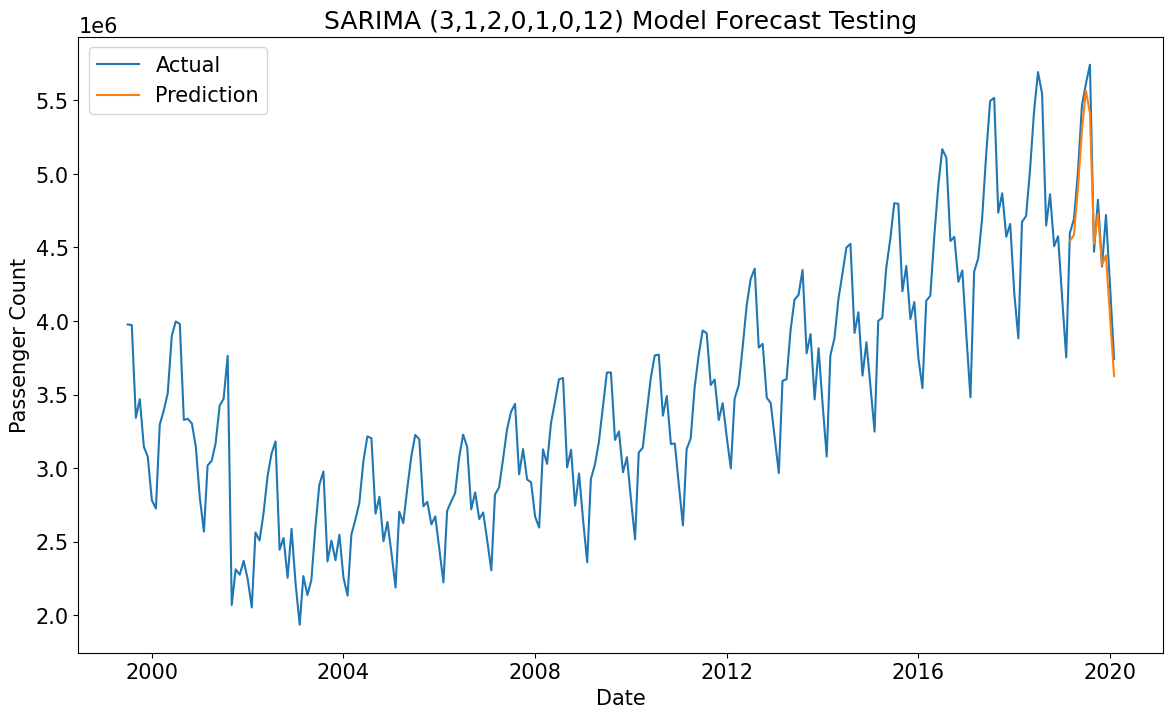

In [216]:
plt.plot(df_pre_covid['date'], df_pre_covid['passenger_count'], label='Actual')
plt.plot(prediction.index, prediction, label='Prediction')
plt.xlabel("Date", size=15)
plt.ylabel("Passenger Count", size=15)
plt.legend()
plt.title('SARIMA (3,1,2,0,1,0,12) Model Forecast Testing')
plt.show()

### Analyze Residuals

In [217]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                   passenger_count   No. Observations:                  236
Model:             ARIMA(3, 1, 2)x(0, 1, [], 12)   Log Likelihood               -2946.648
Date:                           Wed, 17 Jan 2024   AIC                           5905.296
Time:                                   10:00:28   BIC                           5925.739
Sample:                               07-01-1999   HQIC                          5913.549
                                    - 02-01-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8839      0.039    -48.180      0.000      -1.960      -1.807
ar.L2         -1.0386      0.061    -17.027      0.000      -1.158      -0.919
ar.L3         -0.0404      0.030     -1.330      0.184      -0.100       0.019
ma.L1          1.8372      0.029     63.295      0.000       1.780       1.894
ma.L2          0.9459      0.028     33.294      0.000       0.890       1.002
sigma2       1.85e+10   1.26e-12   1.47e+22      0.000    1.85e+10    1.85e+10
===================================================================================
Ljung-Box (L1) (Q):                   5.42   Jarque-Bera (JB):              2291.76
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.3e+37. Standard errors may be unstable.
"""

Prob(Q) and Prob(JB) are 0 which means they both reject the null hypothesis which states that the residuals are `normally distributed` and `uncorrelated` 

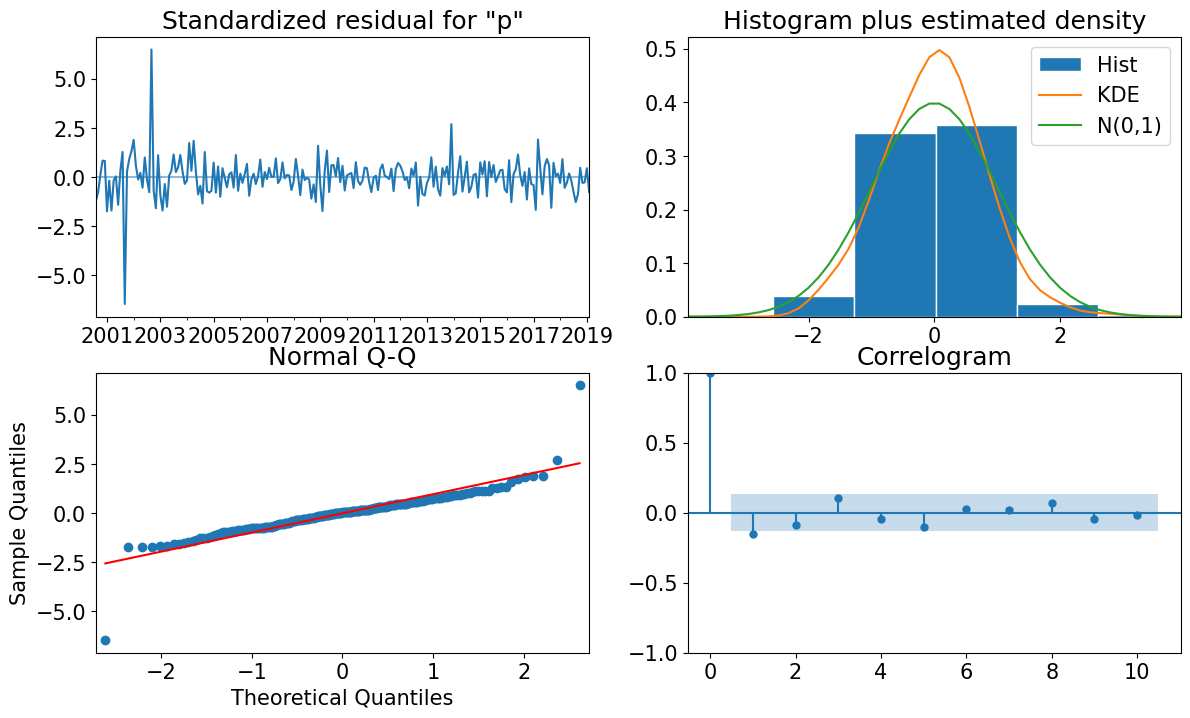

In [218]:
results.plot_diagnostics()
plt.show()

Explanation:
1. Upper left: the residuals have constant variance
2. Upper right and lower left: due to the the lines are close each other, the dots are quite far away from from the expected red line
3. Lower right: the percentage of values that aren't significant is below 95%.

Overall it is better thatn using the ARIMA

### Evaluate Results

In [219]:
print(f"Bias: {bias(test_pre_covid['passenger_count'], prediction):.2f}")
print(f"MAE: {mae(test_pre_covid['passenger_count'], prediction):.2f}")
print(f"MAPE: {mape(test_pre_covid['passenger_count'], prediction):.2f}%")

Bias: -120876.19
MAE: 131763.17
MAPE: 2.73%


Achieve better performance than ARIMA

## Pre Covid Forecast

In [220]:
# Train Arima Using The Best (p, d, s) Params
best_p, best_d, best_q = (3, 1, 2)
best_arima_model = ARIMA(
    endog=df_pre_covid.set_index('date'),
    order=(best_p, best_d, best_q),
    seasonal_order=(0, 1, 0, 12),
    freq='MS'
)
results = best_arima_model.fit()

# Predict Using ARIMA
prediction = results.get_forecast(steps=12).predicted_mean

c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


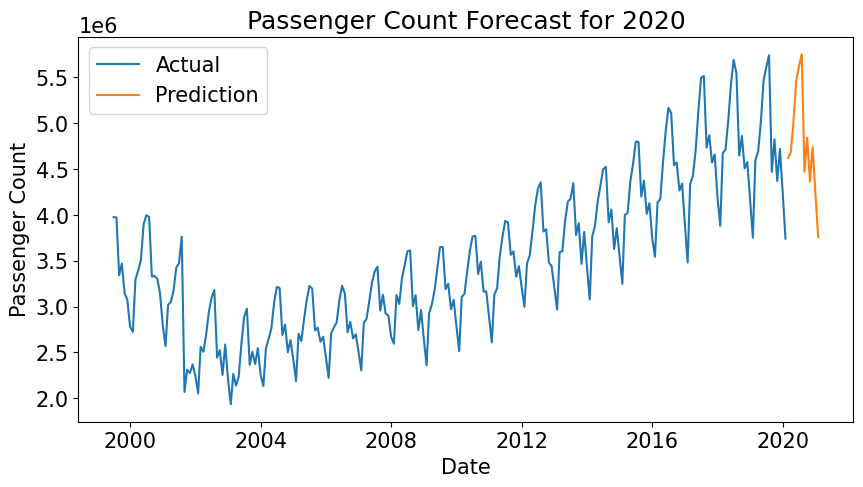

In [221]:
plt.figure(figsize=(10, 5))
plt.plot(df_pre_covid['date'], df_pre_covid['passenger_count'], label='Actual')
plt.plot(prediction.index, prediction, label='Prediction')
plt.xlabel("Date", size=15)
plt.ylabel("Passenger Count", size=15)
plt.legend()
plt.title('Passenger Count Forecast for 2020')
plt.show()

# Post Covid

## Modelling ARIMA

### Find Best Parameter

In [167]:
# find the best model for the ARIMA method
best_p, best_d, best_q = None, None, None
d=1
best_aic = float('inf')
for p in range(0, 4):
    for q in range(0, 4):
        model = ARIMA(
            endog=train_post_covid.set_index('date'),
            order=(p, d, q),
            freq='MS'
        )
        results = model.fit()
        if best_aic > results.aic:
            best_p, best_d, best_q = (p, d, q)
            best_aic = results.aic

print(f"Best Params (p, d, q): {(best_p, best_d, best_q)}")

# Train Arima Using The Best (p, d, s) Params
best_arima_model = ARIMA(
    endog=train_post_covid.set_index('date'),
    order=(best_p, best_d, best_q),
    freq='MS'
)
results = best_arima_model.fit()
# Predict Using ARIMA
prediction = results.get_forecast(steps=12).predicted_mean

c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\923

Best Params (p, d, q): (0, 1, 0)


### Plot the Results

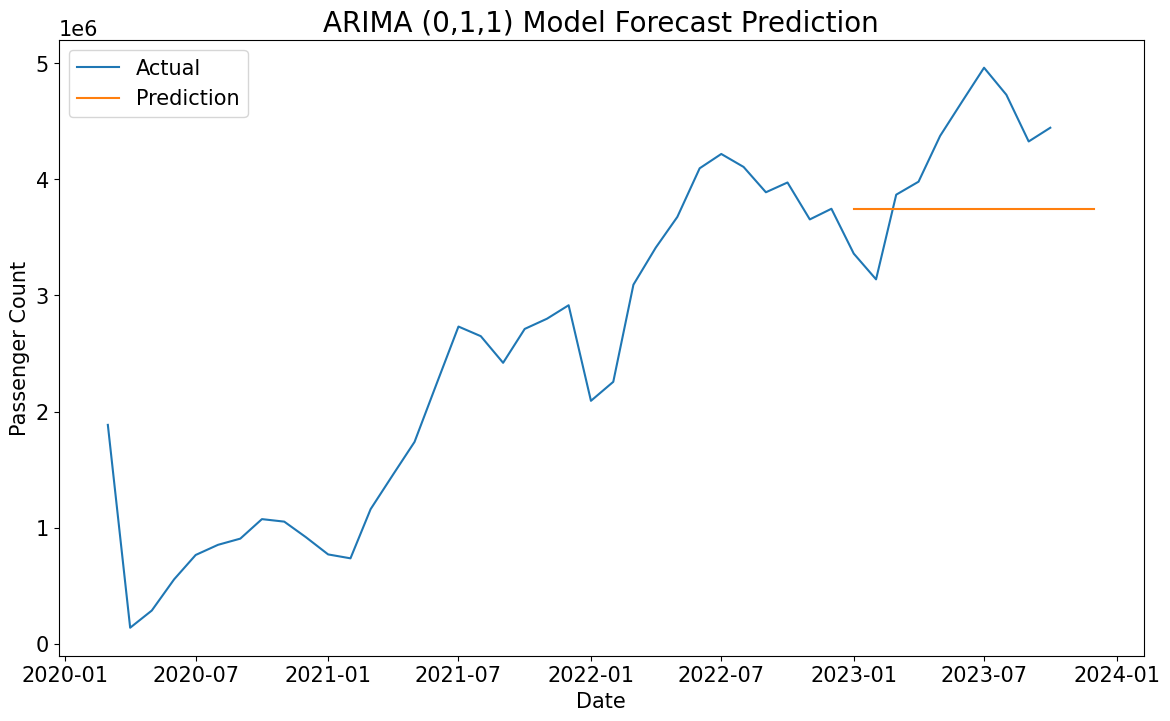

In [168]:
plt.plot(df_post_covid['date'], df_post_covid['passenger_count'], label='Actual')
plt.plot(prediction.index, prediction, label='Prediction')
plt.xlabel("Date", size=15)
plt.ylabel("Passenger Count", size=15)
plt.legend()
plt.title('ARIMA (0,1,1) Model Forecast Prediction', size=20)
plt.show()

### Analyze Residuals

In [169]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        passenger_count   No. Observations:                   34
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -475.204
Date:                Wed, 17 Jan 2024   AIC                            952.407
Time:                        09:54:33   BIC                            953.904
Sample:                    03-01-2020   HQIC                           952.911
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.829e+11   2.19e+10      8.353      0.000     1.4e+11    2.26e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):               101.05
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                            -2.22
Prob(H) (two-sided):                  0.13   Kurtosis:                        10.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Prob(Q) are 0.6 which accept the null hypothesis that the distribution of the residuals are `uncorrelated`

Prob(JB) are 0 which means they both reject the null hypothesis which states that the residuals are `normally distributed` 

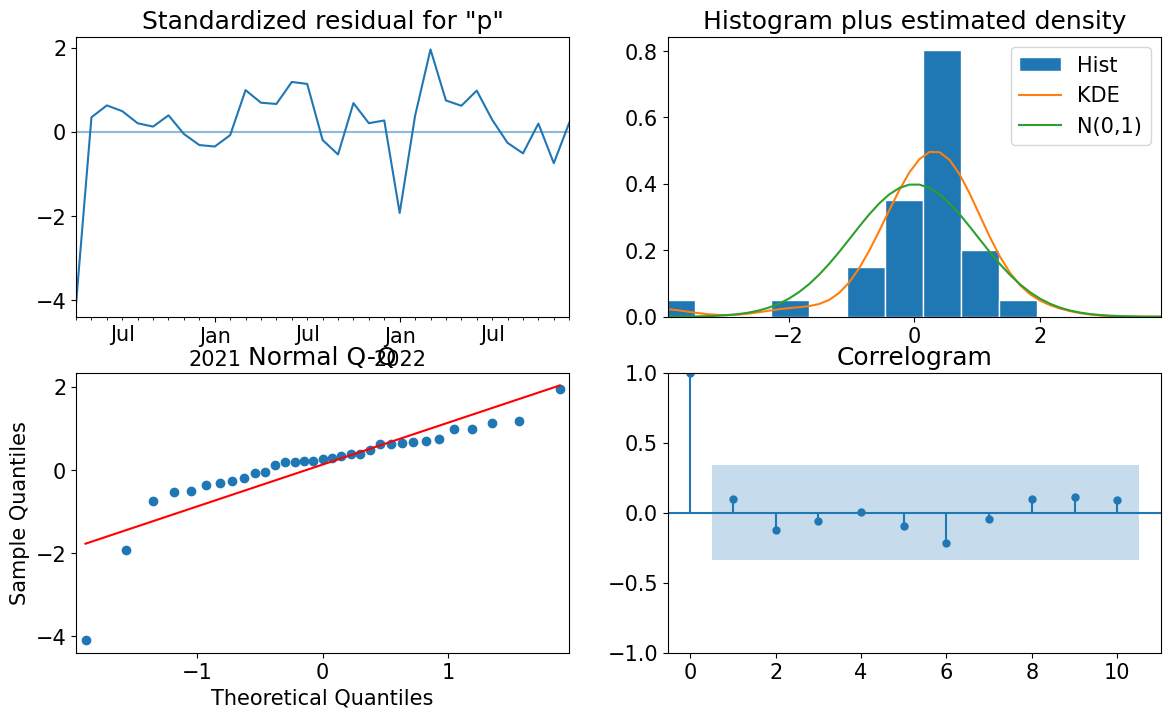

In [170]:
results.plot_diagnostics()
plt.show()

Explanation:
1. Upper left: the residuals are not at constant variance
2. Upper right and lower left: due to the the lines are quite far from each other, the dots are quite far away from from the expected red line
3. Lower right: the percentage of values that aren't significant is below 95%.

### Evaluate Results

In [171]:
print(f"Bias: {bias(test_pre_covid['passenger_count'], prediction):.2f}")
print(f"MAE: {mae(test_pre_covid['passenger_count'], prediction):.2f}")
print(f"MAPE: {mape(test_pre_covid['passenger_count'], prediction):.2f}%")

Bias: -1044922.42
MAE: 1045578.08
MAPE: 20.73%


## Modelling SARIMA

### Find Best Parameter

In [222]:
# find the best model for the ARIMA method
best_p, best_d, best_q = None, None, None
d=1
best_aic = float('inf')
for p in range(0, 4):
    for q in range(0, 4):
        model = ARIMA(
            endog=train_post_covid.set_index('date'),
            order=(p, d, q),
            seasonal_order=(0, 1, 0, 12),
            freq='MS'
        )
        results = model.fit()
        if best_aic > results.aic:
            best_p, best_d, best_q = (p, d, q)
            best_aic = results.aic

print(f"Best Params (p, d, q): {(best_p, best_d, best_q)}")

# Train Arima Using The Best (p, d, s) Params
best_arima_model = ARIMA(
    endog=train_post_covid.set_index('date'),
    order=(best_p, best_d, best_q),
    seasonal_order=(0, 1, 0, 12),
    freq='MS'
)
results = best_arima_model.fit()
# Predict Using ARIMA
prediction = results.get_forecast(steps=12).predicted_mean

### Plot the Results

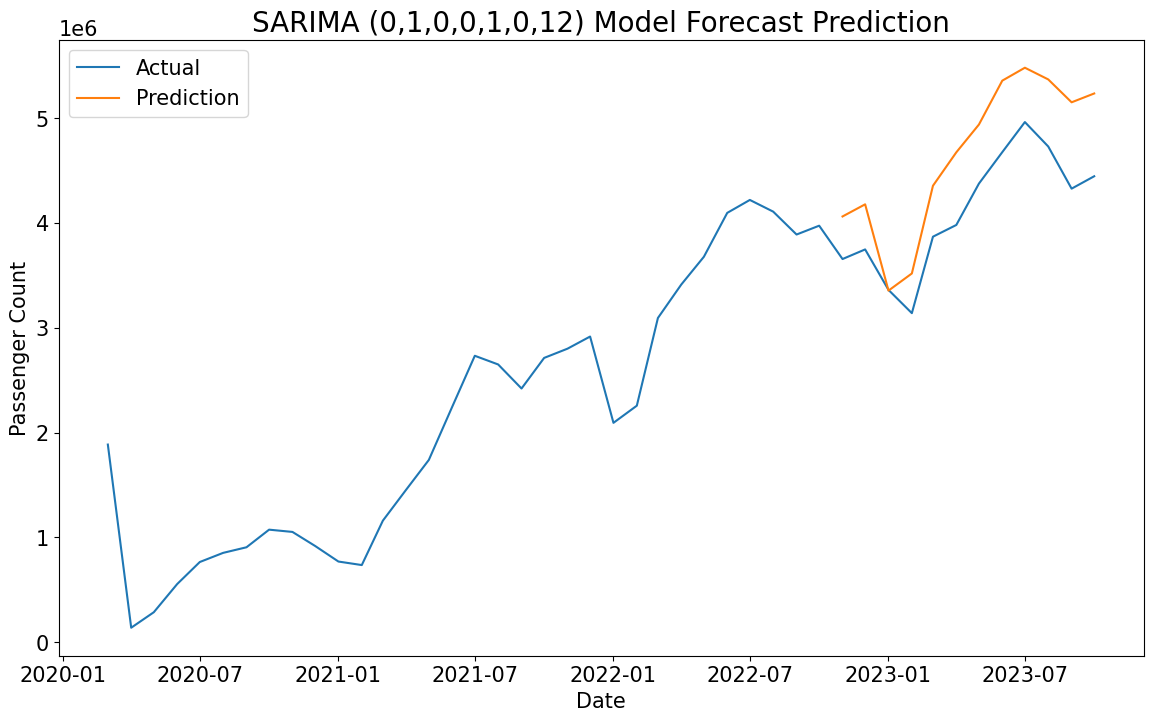

In [206]:
plt.plot(df_post_covid['date'], df_post_covid['passenger_count'], label='Actual')
plt.plot(prediction.index, prediction, label='Prediction')
plt.xlabel("Date", size=15)
plt.ylabel("Passenger Count", size=15)
plt.legend()
plt.title('SARIMA (0,1,0,0,1,0,12) Model Forecast Prediction', size=20)
plt.show()

### Analyze Residuals

In [207]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                  passenger_count   No. Observations:                   32
Model:             ARIMA(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -278.998
Date:                          Wed, 17 Jan 2024   AIC                            559.995
Time:                                  09:58:34   BIC                            560.940
Sample:                              03-01-2020   HQIC                           560.155
                                   - 10-01-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.678e+11   1.39e+10     12.072      0.000    1.41e+11    1.95e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                62.43
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                             2.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Prob(Q) is 0.94 which is bigger than 0.05. That means the residuals are `uncorrelated`. 

Prob(JB) is 0.46 which is bigger than 0.05. That means the residuals are `normally distributed`. 

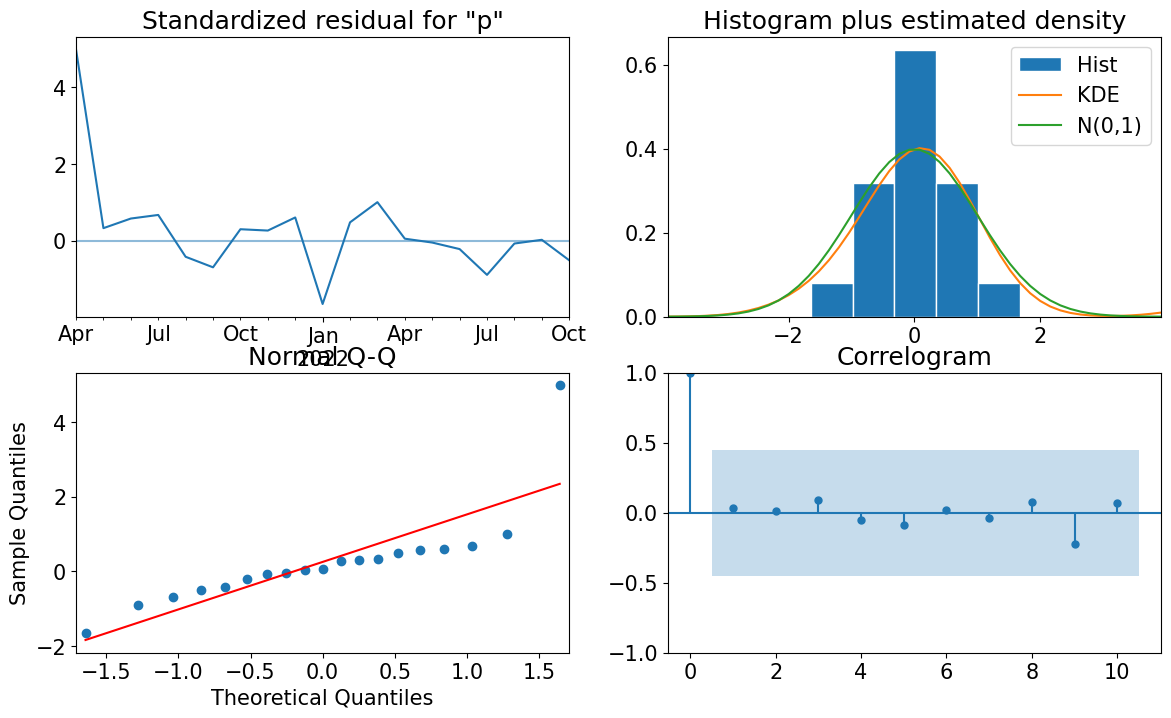

In [208]:
results.plot_diagnostics()
plt.show()

Explanation:
1. Upper left: the residuals have constant variance
2. Upper right and lower left: due to the the lines are close each other, the dots are quite far away from from the expected red line
3. Lower right: the percentage of values that aren't significant is below 95%.

Overall it is better thatn using the ARIMA

### Evaluate Results

In [211]:
print(f"Bias: {bias(test_post_covid['passenger_count'], prediction):.2f}")
print(f"MAE: {mae(test_post_covid['passenger_count'], prediction):.2f}")
print(f"MAPE: {mape(test_post_covid['passenger_count'], prediction):.2f}%")

Bias: 533477.42
MAE: 534612.42
MAPE: 12.75%


In [192]:
test_post_covid

,date,passenger_count
279,2022-10-01,3972446
280,2022-11-01,3654498
281,2022-12-01,3746158
282,2023-01-01,3360186
283,2023-02-01,3138399
284,2023-03-01,3867517
285,2023-04-01,3979317
286,2023-05-01,4373786
287,2023-06-01,4673688
288,2023-07-01,4960657


Achieve better performance than ARIMA

## Post Covid Forecast

In [212]:
# Train Arima Using The Best (p, d, s) Params
best_p, best_d, best_q = (0, 1, 0)
best_arima_model = ARIMA(
    endog=df_post_covid.set_index('date'),
    order=(best_p, best_d, best_q),
    seasonal_order=(0, 1, 0, 12),
    freq='MS'
)
results = best_arima_model.fit()
# Predict Using ARIMA
prediction = results.get_forecast(steps=12).predicted_mean

c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


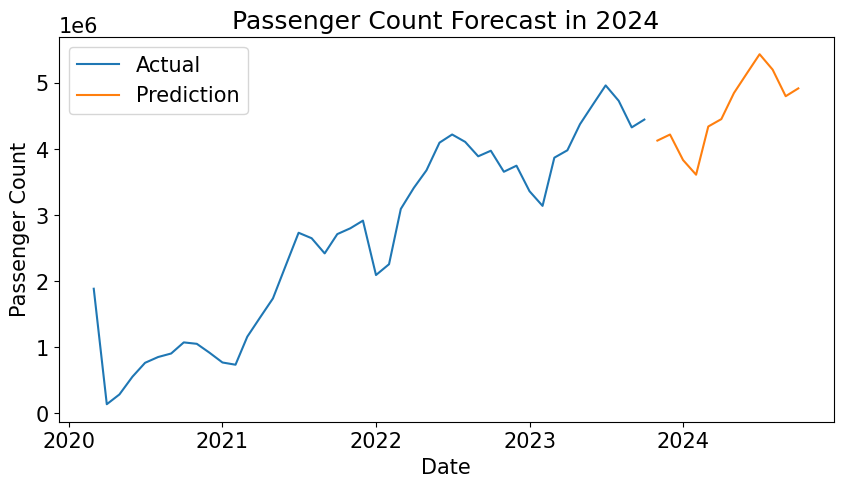

In [213]:
plt.figure(figsize=(10, 5))
plt.plot(df_post_covid['date'], df_post_covid['passenger_count'], label='Actual')
plt.plot(prediction.index, prediction, label='Prediction')
plt.xlabel("Date", size=15)
plt.ylabel("Passenger Count", size=15)
plt.legend()
plt.title('Passenger Count Forecast in 2024')
plt.show()